In [197]:
from src.preprocessing.text_preprocessing import clean_text, transform_countvec, transform_tfidf
import src.models.models as models
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatterExponent

In [35]:
train_raw = pd.read_csv("data/train.csv")
test_raw = pd.read_csv("data/test.csv")
y_test_raw = pd.read_csv("data/submit.csv")
test_raw = test_raw.join(y_test_raw["label"])

train_clean = clean_text(train_raw)
test_clean = clean_text(test_raw)
y_train = train_clean["label"].to_numpy()
y_test = test_clean["label"].to_numpy()


c:\Users\aupab\Desktop\mathml_final_proj\mathml_finalproj\src\preprocessing\text_preprocessing.py:28: FutureWarning: The default value of regex will change from True to False in a future version.
  col = col.str.replace('[^\w\s]', '')\


In [25]:
X_train, X_test, words = transform_tfidf(train_clean["text"], test_clean["text"])
X_train = X_train.todense()

In [26]:
y_train = y_train.to_numpy()
X_train.shape

(18285, 16770)

(5200,)

In [190]:
n, p = X_train.shape
indices = np.random.permutation(n)
X_train = X_train[indices,:]
y_train = y_train[indices]
folds = 3
n_alphas = 10
lambdas = [0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]

avg_errors_by_penalty = np.empty((n_alphas + 1,len(lambdas)))

In [288]:
import numpy as np


def gradient_descent(x_train, x_dev, y_train, y_dev, n_alphas, lambda_):
    '''
    '''

    alphas = np.linspace(0, 1, n_alphas+1)
    errors_alpha_i = np.zeros(n_alphas+1)

    for i, alpha in enumerate(alphas):
        w = sgd(x_train, y_train, alpha, lambda_, 0.001)
        pred = (1 / (1 + np.exp(-x_dev.dot(w)))).A1
        
        errors_alpha_i[i] = np.mean((-y_dev*np.log(pred)) - ((1-y_dev)*np.log(pred)))

    return errors_alpha_i


def sgd(X, y, alpha, lambda_, eta, epochs=10000): 
    '''
    '''
    n, p = X.shape
    l1 = alpha*lambda_
    l2 = (1-alpha)*lambda_

    w = np.ones(p)
    dw = np.zeros(p)

    for _ in range(epochs):
        i = np.random.randint(0, n)
        x_i = X[i]
        y_i = y[i]

        pred_i = 1 / (1 + np.exp(-x_i.dot(w)))

        dw = -1* (y_i - pred_i)* x_i + l1*np.sign(w) + 2*l2*w

        w = w - eta * dw
        w = w.A1

    return w


In [287]:
for i, lambda_ in enumerate(lambdas):
    errors = np.empty((n_alphas+ 1,folds))
    buckets = list(range(0, n + 1, n//folds))
    
    for k in range(folds):
        val1 = buckets[k]
        val2 = buckets[k+1]

        x_dev = X_train[val1:val2,:]
        x_train = np.delete(X_train, np.s_[val1:val2], axis=0)

        y_dev = y_train[val1:val2]
        y_train2 = np.delete(y_train, np.s_[val1:val2], axis=0)

        errors[:,k] = gradient_descent(x_train, x_dev, y_train2, y_dev,n_alphas, lambda_)

    avg_errors_by_penalty[:,i] = np.mean(errors, axis=1)

KeyboardInterrupt: 

In [194]:
print(avg_errors_by_penalty)

[[0.00781072 0.00579872 0.00564903 0.00563377 0.00563086 0.00563253
  0.00563144]
 [0.00768614 0.00579    0.00564646 0.00563291 0.00563095 0.00563336
  0.00563178]
 [0.00756514 0.00578287 0.00564675 0.00563266 0.00563236 0.00563128
  0.00563199]
 [0.0074394  0.00577551 0.00564729 0.00563226 0.00563116 0.00563123
  0.00563256]
 [0.0073209  0.00576608 0.00564513 0.00563401 0.00563145 0.00563095
  0.00563133]
 [0.00719837 0.00575716 0.00564389 0.00563378 0.00563213 0.0056322
  0.00563046]
 [0.00708869 0.00574692 0.00564328 0.00563285 0.00563231 0.00563164
  0.00563173]
 [0.00697283 0.00574043 0.00564339 0.00563388 0.00563095 0.00563174
  0.00563068]
 [0.00685826 0.00573257 0.00564185 0.00563282 0.00563271 0.00563226
  0.00563161]
 [0.00674772 0.0057233  0.00564177 0.00563291 0.00563142 0.00563299
  0.00563245]
 [0.00663825 0.00571339 0.00564032 0.00563297 0.00563273 0.00563213
  0.00563175]]


In [286]:
def get_best_vals(avg_err_array, lambdas):
    ind_ridge = (np.where(avg_err_array[0] == avg_err_array[0].min())[0][0])
    ind_lasso = (np.where(avg_err_array[10] == avg_err_array[10].min())[0][0])

    enl_matrix = avg_err_array[1:10]
    alpha_idx, en_lambda_idx = np.where(enl_matrix == np.min(enl_matrix))
    alpha_idx += 1

    ridge_lambda = lambdas[ind_ridge]
    lasso_lambda = lambdas[ind_lasso]
    en_lambda = lambdas[en_lambda_idx[0]]
    best_alpha = alpha_idx[0] * 0.1

    return  ridge_lambda, lasso_lambda, en_lambda, best_alpha



<AxesSubplot:title={'center':'Average Error by Model Specification'}, xlabel='lambda', ylabel='Average Error Rate'>

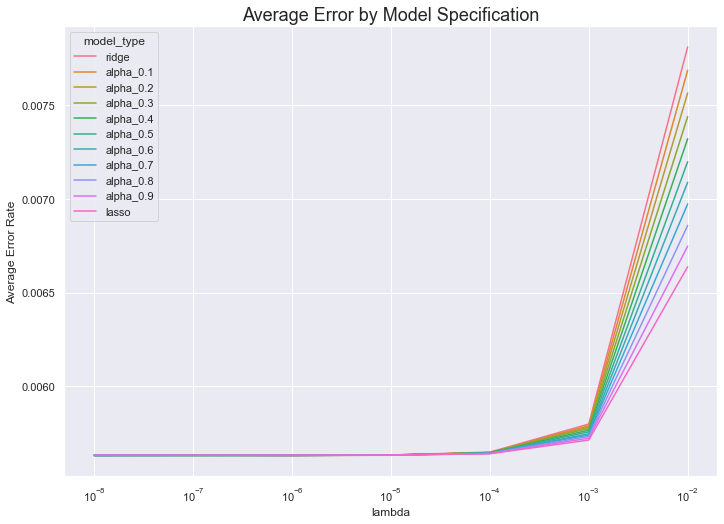

In [199]:
def make_graph_from_array(avg_errs, title='Average Error by Model Specification'):
    """
    Inputs: avg_error array
    Outputs: Graph
    imports needed:
        import pandas as pd
        import seaborn as sns
        import matplotlib.pyplot as plt
        from matplotlib.ticker import LogFormatterExponent
    """
    pd.set_option("display.precision", 8)

    df = pd.DataFrame(avg_errs.T, columns = ['ridge','alpha_0.1','alpha_0.2',
                                                        'alpha_0.3','alpha_0.4','alpha_0.5',
                                                        'alpha_0.6','alpha_0.7','alpha_0.8',
                                                        'alpha_0.9', 'lasso'])

    df.insert(0,'lambda', [0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001])

    df_melt = pd.melt(df, id_vars=['lambda'], 
                          value_vars=['ridge', 'alpha_0.1',
                                      'alpha_0.2', 'alpha_0.3', 'alpha_0.4', 
                                      'alpha_0.5', 'alpha_0.6', 'alpha_0.7',
                                      'alpha_0.8', 'alpha_0.9', 'lasso'],
                          var_name='model_type',
                          value_name='avg_err' )

    sns.set(rc={'figure.figsize':(11.7,8.27)})

    ax = sns.lineplot(x='lambda', y='avg_err', data=df_melt, hue='model_type')
    ax.set_xscale('log')
    ax.set_title(title, fontsize=18)
    ax.set_ylabel('Average Error Rate')
    return ax


make_graph_from_array(avg_errs=avg_errors_by_penalty)

In [200]:
ridge_lambda, lasso_lambda, en_lambda, best_alpha = get_best_vals(avg_errors_by_penalty, lambdas)

In [201]:
print(ridge_lambda)
print(lasso_lambda)
print(en_lambda)
print(best_alpha)

1e-06
1e-08
1e-08
0.5


In [290]:
def predict(X_train, y_train, X_test, alpha, lambda_, eta, epochs):
    '''
    '''
    w = sgd(X_train, y_train, alpha, lambda_, eta, epochs)
    pred = (1 / (1 + np.exp(-X_test.dot(w))))

    return pred

def pred_to_accuracy(pred, y_test, threshold):
    '''
    '''
    pred_label = np.where(pred > threshold, 1, 0)
    errors = abs(y_test - pred_label)
    accuracy = sum(errors)/len(errors)

    return accuracy


In [312]:
pred_ridge = predict(X_train, y_train,  X_test, 0, ridge_lambda, 0.001, 10000)
pred_lasso = predict(X_train, y_train,  X_test, 1, lasso_lambda, 0.001, 10000)
pred_en = predict(X_train, y_train,  X_test, best_alpha, en_lambda, 0.001, 10000)

In [318]:
threshold = 0.9999
accuracy_r = pred_to_accuracy(pred_ridge, y_test, threshold)
accuracy_l = pred_to_accuracy(pred_lasso, y_test, threshold)
accuracy_en = pred_to_accuracy(pred_en, y_test, threshold)
print(accuracy_r)
print(accuracy_l)
print(accuracy_en)


0.8688524590163934
0.8686338797814208
0.8684153005464481
